## Google landmark recognition challenge - Data Exploration
Use deep learning to recognize landmarks worldwide

### Load dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
sns.set_theme()

import h5py
from urllib.parse import unquote
import os
import textwrap
from skimage import io

### Data exploration

#### Loading datasets

There are three datasets for the recognition challenge:
- a full training dataset
- a cleaned training dataset
- a test set

In [2]:
df = pd.read_csv('data/train_clean.csv')

In [3]:
# shape of the clean training dataset
df.shape

(81313, 2)

The images column contain multiple image ids that belong to the same landmark id.

In [4]:
df.head()

,landmark_id,images
0,1,17660ef415d37059 92b6290d571448f6 cd41bf948edc...
1,7,25c9dfc7ea69838d 28b13f94a6f1f3c1 307d6584f473...
2,9,0193b65bb58d2c77 1a30a51a287ecf69 1f4e8ab1f1b2...
3,11,1a6cb1deed46bb17 1cc2c8fbc83e1a0c 2361b8da868c...
4,12,0a199c97c382b1ff 1492a5d344495391 290097bd36a6...


In [5]:
# check for missing values
df.isnull().sum()

landmark_id    0
images         0
dtype: int64

The number of images match with the image count from [Github repo](https://github.com/cvdfoundation/google-landmark). 

In [6]:
# count the total image ids
(df['images'].str.split().map(len)).sum()

1580470

In [7]:
full_df = pd.read_csv('data/train.csv')

In [8]:
full_df.head()

,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


In [9]:
# shape of the full training dataset
full_df.shape

(4132914, 3)

In [10]:
# check for missing values
full_df.isnull().sum()

id             0
url            0
landmark_id    0
dtype: int64

In [11]:
# number of unique classes
full_df['landmark_id'].nunique()

203094

In [12]:
full_df['landmark_id'].max(), full_df['landmark_id'].min()

(203093, 0)

The next steps are for marking images as clean in the full dataset.

In [13]:
# merge the images column with the full dataset
merged = pd.merge(full_df, df, on='landmark_id', how='left')

In [14]:
merged.head()

,id,url,landmark_id,images
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,072bd23acd6e0daa 1034d5cb0eec963f 309116d47194...
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,00f420f0919df077 0191468916aa2b3d 02447c4db02d...
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,10fa200308bb85c0 58ffef7890dd04bb 5a1fb832958e...
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,00bb8375530c80e4 02b2f0f983648fe6 04f83e093497...
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,0161c12b4a9a4872 05b389abc8c83bb0 097f6f8b9952...


In [15]:
# if the image id is contained in images column, then mark it as clean
merged['clean'] = merged.apply(lambda row: str(row['id']) in str(row['images']), axis=1)

In [16]:
merged.head()

,id,url,landmark_id,images,clean
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,072bd23acd6e0daa 1034d5cb0eec963f 309116d47194...,False
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,00f420f0919df077 0191468916aa2b3d 02447c4db02d...,True
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,10fa200308bb85c0 58ffef7890dd04bb 5a1fb832958e...,False
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,00bb8375530c80e4 02b2f0f983648fe6 04f83e093497...,True
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,0161c12b4a9a4872 05b389abc8c83bb0 097f6f8b9952...,False


In [17]:
# number of clean images align with the clean dataset
merged['clean'].sum()

1580470

#### Understanding the class distribution
- There is a huge class imbalance - some classes have thousands of samples, while others only have one. 
- The most frequent class has more than 10k images.

In [18]:
counts = merged['landmark_id'].value_counts()
counts

138982    10247
62798      4333
177870     3327
176528     3243
192931     2627
          ...  
136433        1
57618         1
143482        1
156927        1
144312        1
Name: landmark_id, Length: 203094, dtype: int64

In [19]:
# statistics for mean, max, min and median
counts.mean(), counts.max(), counts.min(), counts.median()

(20.34975922479246, 10247, 1, 8.0)

In [20]:
quantiles = np.arange(0.1, 1, 0.1)

for q in quantiles:
    print(f'{int(q*100)}% of classes have less than or equal to {int(counts.quantile(q))} images')

10% of classes have less than or equal to 2 images
20% of classes have less than or equal to 3 images
30% of classes have less than or equal to 4 images
40% of classes have less than or equal to 6 images
50% of classes have less than or equal to 8 images
60% of classes have less than or equal to 12 images
70% of classes have less than or equal to 17 images
80% of classes have less than or equal to 25 images
90% of classes have less than or equal to 46 images


About 30% of classes make up 80% of images.

In [21]:
n = 0.8
idx = int(np.argwhere((counts.cumsum() / merged.shape[0] >= n).values)[0])
print(
    f'{idx} classes make up about {int(n*100)}% of all images.\n'
    f'That is equivalently {((idx/merged["landmark_id"].nunique())*100):.2f}% of classes.'
)

62775 classes make up about 80% of all images.
That is equivalently 30.91% of classes.


#### Visualizing the distribution
<!-- - Among the top 100 most frequent classes, the sample counts decrease quickly.
- The difference between the top two classes is steep. -->

In [22]:
counts_df = pd.DataFrame(counts)
counts_df.reset_index(drop=True, inplace=True)
counts_df.rename(columns={'landmark_id':'count'}, inplace=True)

The following plot with a log-scaled y axis shows that the sample count has a long-tailed distribution.

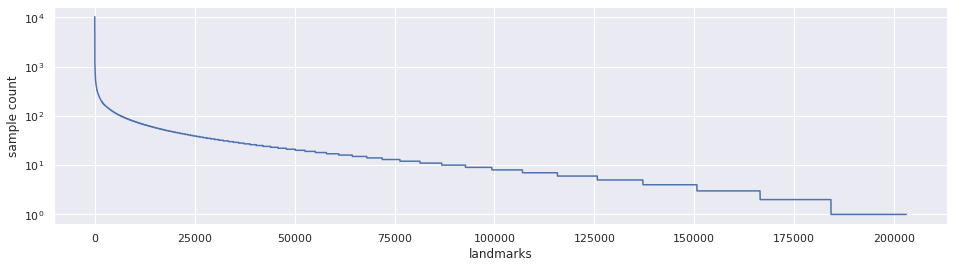

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

counts_df['count'].plot(ax=ax)
plt.yscale('log')
plt.ylabel('sample count')
plt.xlabel('landmarks');

In [24]:
num_bins = 14
bins = np.logspace(0, np.log2(10248), num_bins, base=2).astype(int)
bins

array([    1,     2,     4,     8,    17,    34,    70,   144,   293,
         597,  1216,  2475,  5036, 10248])

In [25]:
cats = pd.cut(counts_df['count'], bins=bins, right=False).value_counts()
cats

[8, 17)          45956
[4, 8)           43663
[2, 4)           33541
[17, 34)         31046
[1, 2)           18894
[34, 70)         18495
[70, 144)         8162
[144, 293)        2597
[293, 597)         591
[597, 1216)        121
[1216, 2475)        22
[2475, 5036)         5
[5036, 10248)        1
Name: count, dtype: int64

In [26]:
cats_df = pd.DataFrame(cats)

In [27]:
cats_df.index = cats_df.index.astype(str).map(lambda x: x[1:-1]).str.replace(',', ' -')

Below is an overview of the number of classes in each sample count interval.

One can see that most classes have between 8 to 17 images.

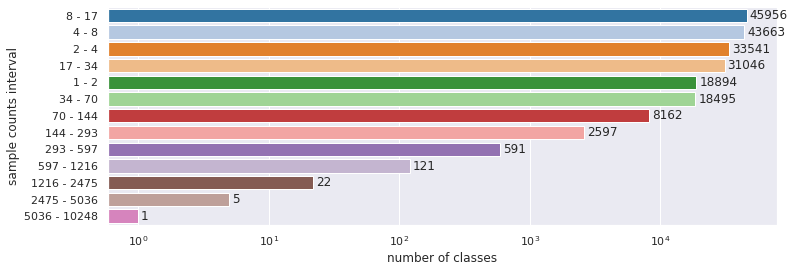

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
bar_ax = sns.barplot(
    data=cats_df, 
    x='count',
    y=cats_df.index,
    order=cats_df.index, 
    ax=ax, 
    palette='tab20')
plt.xscale('log')
bar_ax.set(xlabel='number of classes', ylabel='sample counts interval')
for p in bar_ax.patches:
    width = p.get_width()
    bar_ax.annotate(
        int(width),
        xy=(width, p.get_y() + p.get_height() / 2),
        xytext=(3, 0),
        textcoords='offset points',
        ha='left', va='center'
    )

#### Matching labels to landmarks

Additional information on the categories of landmark IDs.

In [29]:
landmark = pd.read_csv('data/train_label_to_category.csv')

In [30]:
landmark.head()

,landmark_id,category
0,0,http://commons.wikimedia.org/wiki/Category:Hap...
1,1,http://commons.wikimedia.org/wiki/Category:Lui...
2,2,http://commons.wikimedia.org/wiki/Category:Gra...
3,3,http://commons.wikimedia.org/wiki/Category:Twe...
4,4,http://commons.wikimedia.org/wiki/Category:San...


In [31]:
# check for missing values
landmark.isnull().sum()

landmark_id    0
category       0
dtype: int64

In [32]:
# row count of landmark df should be the same as unique labels of full training dataset
landmark.shape

(203094, 2)

In [33]:
landmark.iloc[0]['category']

'http://commons.wikimedia.org/wiki/Category:Happy_Valley_Racecourse'

In [34]:
# parse the category column from url into the specific landmark category
landmark['category'] = landmark['category'].str.extract(r'Category:(.+)', expand=False).map(unquote)

In [35]:
# merge the category column with the merged df
merged_df = pd.merge(merged, landmark, on='landmark_id', how='left')

In [36]:
merged_df.head()

,id,url,landmark_id,images,clean,category
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,072bd23acd6e0daa 1034d5cb0eec963f 309116d47194...,False,Stockholms_gamla_observatorium
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,00f420f0919df077 0191468916aa2b3d 02447c4db02d...,True,Stirling_Castle
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,10fa200308bb85c0 58ffef7890dd04bb 5a1fb832958e...,False,Dynamikum
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,00bb8375530c80e4 02b2f0f983648fe6 04f83e093497...,True,Estadio_Deportivo_Cali
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,0161c12b4a9a4872 05b389abc8c83bb0 097f6f8b9952...,False,River_Severn


In [37]:
merged_df['landmark_id'].nunique()

203094

In [38]:
# drop the images and url column
merged_df = merged_df.drop(columns=['images', 'url'])

In [39]:
# add a file path column in line with the instructions
merged_df['file_path'] = merged_df['id'].map(lambda x: os.path.join('train', x[0], x[1], x[2], f'{x}.jpg'))

In [40]:
merged_df = merged_df.take(np.random.permutation(len(merged_df))).reset_index(drop=True)

In [41]:
merged_df.head()

,id,landmark_id,clean,category,file_path
0,5d163acbb6f03e36,189446,False,Castle_of_Peñíscola,train/5/d/1/5d163acbb6f03e36.jpg
1,83c68176804d2e34,140036,False,Cementerio_Católico_de_Santiago,train/8/3/c/83c68176804d2e34.jpg
2,21c68849b81c7bf5,190176,True,Deichmühle_(Norden),train/2/1/c/21c68849b81c7bf5.jpg
3,4b7634ec28766a10,111337,False,Castello_di_Montmayeur,train/4/b/7/4b7634ec28766a10.jpg
4,173681004700d7a4,171476,True,Toyohashi_Station,train/1/7/3/173681004700d7a4.jpg


In [42]:
merged_df.shape

(4132914, 5)

#### Exploring the clean dataset

In [43]:
# only keep clean images
clean_df = merged_df[merged_df['clean'] == 1]

In [44]:
clean_df.shape

(1580470, 5)

In [45]:
clean_df['landmark_id'].nunique()

81313

In [46]:
clean_df.head()

,id,landmark_id,clean,category,file_path
2,21c68849b81c7bf5,190176,True,Deichmühle_(Norden),train/2/1/c/21c68849b81c7bf5.jpg
4,173681004700d7a4,171476,True,Toyohashi_Station,train/1/7/3/173681004700d7a4.jpg
6,c9b37cfa75c467c8,73428,True,"Tintern_Abbey,_County_Wexford",train/c/9/b/c9b37cfa75c467c8.jpg
7,4e2aca94492b28e3,106625,True,Perrine_Bridge,train/4/e/2/4e2aca94492b28e3.jpg
12,5cd5860f683d8250,11781,True,"Tudor_House,_Southampton",train/5/c/d/5cd5860f683d8250.jpg


In [47]:
clean_df = clean_df.take(np.random.permutation(len(clean_df))).reset_index(drop=True)

The top class with over 6k images, 'Media_contributed_by_the_ETH-Bibliothek', doesn't seem to be a landmark. [Wikimedia](https://commons.wikimedia.org/wiki/Category:Media_contributed_by_the_ETH-Bibliothek) page suggests that it is a parent categories of multiple sub-categories.

I decided to exclude this category during training due to the variance in its representations.

In [48]:
lm_df = pd.DataFrame({
    'landmark': clean_df['category'].value_counts().index,
    'counts': clean_df['category'].value_counts(),
    'landmark_id': clean_df['landmark_id'].value_counts().index}).reset_index(drop=True)
lm_df

,landmark,counts,landmark_id
0,Media_contributed_by_the_ETH-Bibliothek,6272,138982
1,"Corktown,_Toronto",2231,126637
2,Noraduz_Cemetery,1758,20409
3,Museum_of_Folk_Architecture_and_Ethnography_in...,1741,83144
4,Salève,1135,113209
...,...,...,...
81308,Hôtel_de_Maîche,2,134114
81309,Amarnath,2,148173
81310,Mundy_Regional_Park,2,179663
81311,Kamajka,2,199396


In [49]:
# remove class 138982
cleaned = clean_df[clean_df['landmark_id']!=138982].copy()

In [50]:
cleaned.shape

(1574198, 5)

Here's a plot for the top 20 classes.

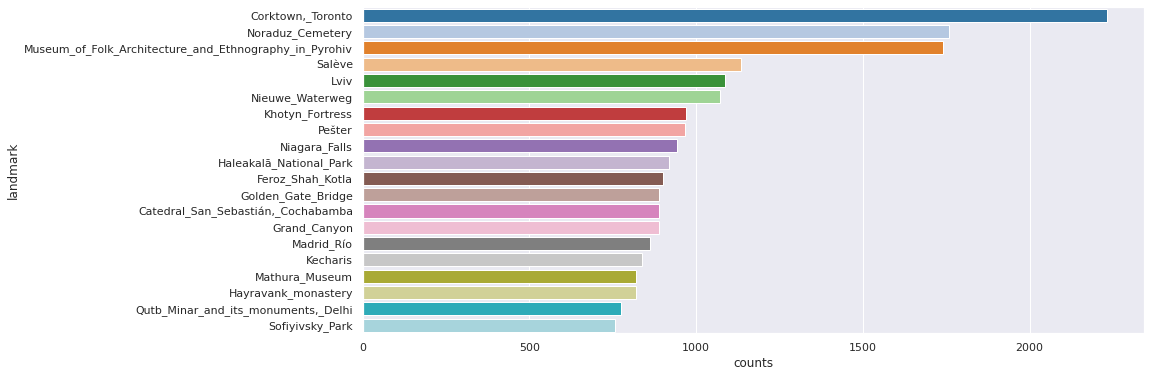

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

sns.barplot(
        data=lm_df[1:21],
        y='landmark',
        x='counts',
        ax=ax,
        palette='tab20'
    );

In [52]:
# shuffle the dataframe
cleaned = cleaned.take(np.random.permutation(len(cleaned))).reset_index(drop=True)

In [53]:
cleaned.head()

,id,landmark_id,clean,category,file_path
0,aa0fe0059f7988b6,98608,True,Grand_Hotel_Europe,train/a/a/0/aa0fe0059f7988b6.jpg
1,c0106568c43ad7b0,75541,True,"Small_Reformed_church,_Târgu_Mureș",train/c/0/1/c0106568c43ad7b0.jpg
2,9eeeb9e7ca079624,127516,True,Burrator,train/9/e/e/9eeeb9e7ca079624.jpg
3,4b4c5668bee97360,19580,True,Lake_Ägeri,train/4/b/4/4b4c5668bee97360.jpg
4,092e494856ecd183,114199,True,Wenguang_Pagoda,train/0/9/2/092e494856ecd183.jpg


#### Splitting training and validation

In [54]:
def train_val_split(df, val_size=0.1):
    shuffled_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
        
    for train_idx, valid_idx in shuffled_split.split(df, df['landmark_id']):
        clean_train_df = df.iloc[train_idx].reset_index(drop=True)
        clean_val_df = df.iloc[valid_idx].reset_index(drop=True)
        
    return clean_train_df, clean_val_df

In [55]:
# saving the training and validation set
train_df, val_df = train_val_split(cleaned)

In [56]:
train_df.shape, val_df.shape

((1416778, 5), (157420, 5))

I take out classes that have less than 10 images for the training set.

In [57]:
id_counts = train_df['landmark_id'].value_counts()
train_df = train_df[train_df['landmark_id'].isin(id_counts[id_counts >= 10].index)]

In [58]:
train_df.shape

(1193789, 5)

In [59]:
train_df['landmark_id'].nunique()

36666

In [60]:
val_df.shape

(157420, 5)

In [61]:
val_df['landmark_id'].nunique()

60704

#### Plotting sample images

In [62]:
def plot_random_images(n_rows, n_cols, df, title=True, landmark_id=None, figsize=(16, 9)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    size = n_rows*n_cols
    if landmark_id:
        imgs = np.random.choice(df[df['landmark_id'] == landmark_id].index,
                                size=size)
    else:
        imgs = np.random.choice(len(df), size=size)
        
    for idx, img_idx in enumerate(imgs):
        file_path = df.loc[img_idx].file_path
        ax = axes.flatten()[idx]
        if title:
            ax.set_title(textwrap.fill(df.loc[img_idx]['category'], width=24))
        img = io.imread(file_path)
        ax.imshow(img)
        ax.axis('off')

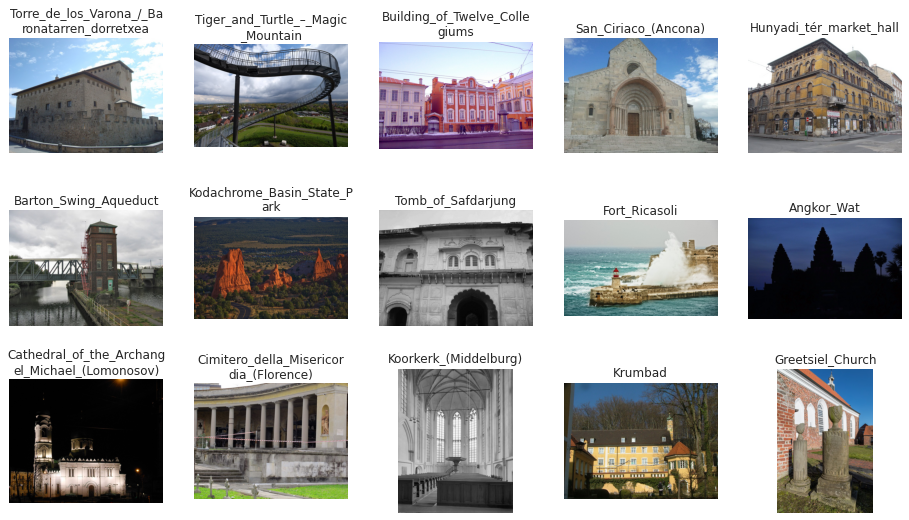

In [63]:
plot_random_images(3, 5, cleaned);

Let's also plot some specific landmarks to inspect the intra-class variance.

In [64]:
def get_landmarks(keyword, top_n=10):
    res = cleaned[cleaned['category'].str.contains(keyword)][['category', 'landmark_id']]
    res_df = pd.DataFrame(res.value_counts()[:top_n]).reset_index()
    res_df.rename(columns={0: 'count'}, inplace=True)
    return res_df

In [65]:
get_landmarks('Good_Hope')

,category,landmark_id,count
0,Castle_of_Good_Hope,458,104
1,Cape_of_Good_Hope,108517,101


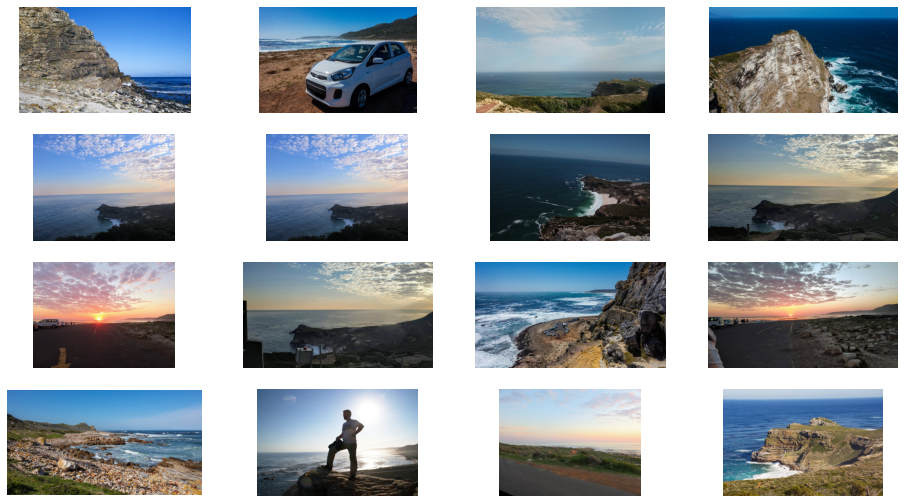

In [66]:
plot_random_images(4, 4, cleaned, title=False, landmark_id=108517);

In [67]:
get_landmarks('Trevi')

,category,landmark_id,count
0,Trevi_fountain,33636,309
1,Chiesa_di_San_Nicolò_(Treviso),58098,30
2,Santi_Vincenzo_e_Anastasio_a_Trevi,190313,20
3,Duomo_(Treviso),67870,17
4,"Santa_Cristina_(Santa_Cristina,_Quinto_di_Trev...",23744,15
5,San_Francesco_(Treviso),101596,13
6,Hermitage_of_Nuestra_Señora_de_Treviño_(Adahue...,153698,8
7,Loggia_dei_Cavalieri_(Treviso),132952,7
8,Visitazione_della_Beata_Vergine_Maria_(Canizza...,169028,6
9,Monumento_ai_Caduti_(Treviso),119830,5


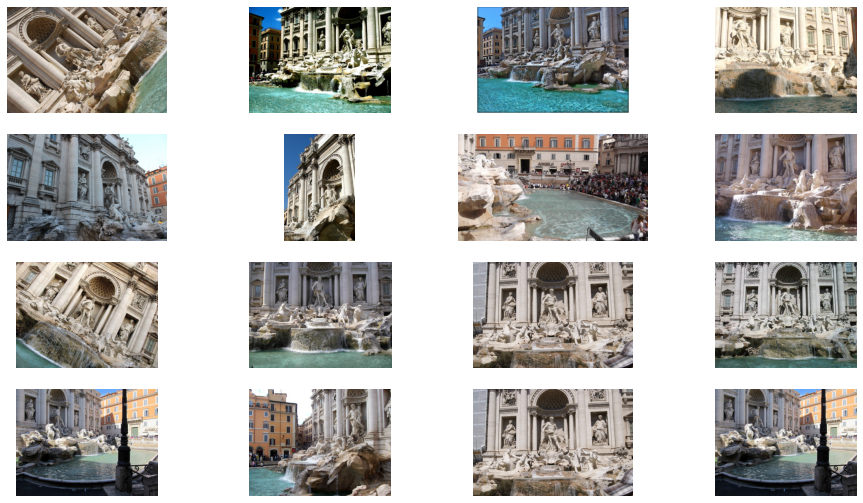

In [68]:
plot_random_images(4, 4, cleaned, title=False, landmark_id=33636);

In [69]:
get_landmarks('Copenhagen')

,category,landmark_id,count
0,Copenhagen_Opera_House,198560,93
1,Port_of_Copenhagen,75213,79
2,"Rådhuspladsen,_Copenhagen",31820,67
3,"Nørrebrogade,_Copenhagen",14671,31
4,St_Albans_Church_Copenhagen,26494,29
5,"Dragon_Fountain,_Copenhagen",189745,16
6,"Alexander_Nevsky_Church,_Copenhagen",152231,15
7,Copenhagen_Admiral_Hotel,82770,14
8,Copenhagen_Concert_Hall,15093,12
9,"Royal_Library_Garden,_Copenhagen",149682,10


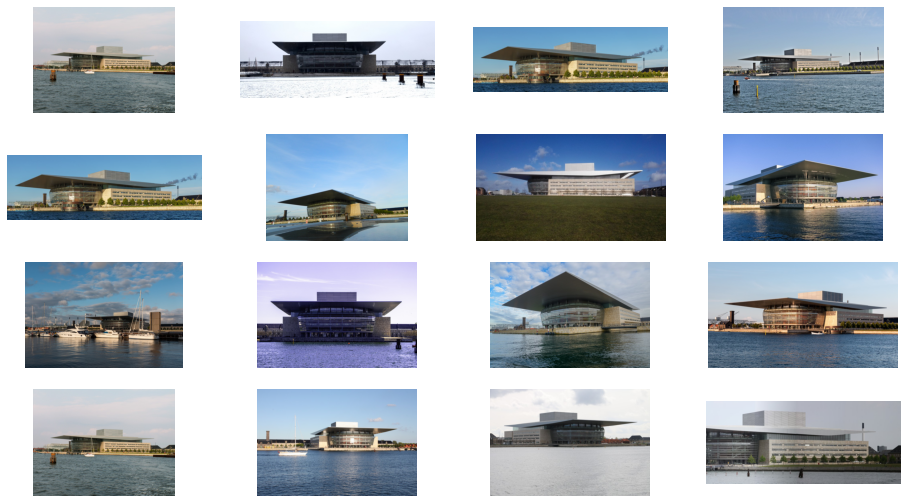

In [70]:
plot_random_images(4, 4, cleaned, title=False, landmark_id=198560);

#### Saving dataframes to disk

In [71]:
# train_df.to_hdf('train.h5', key='train_df', mode='a')
# val_df.to_hdf('train.h5', key='val_df', mode='a')

In [72]:
# print(f'Training set has {len(train_df)} samples.\n'
#      f'Validatation set has {len(val_df)} samples.')

In [73]:
# # saving the original full trainining set and clean training set for query purposes
# merged_df.to_hdf('train.h5', key='db_full_df', mode='a')
# clean_df.to_hdf('train.h5', key='db_clean_df', mode='a')

#### Test dataset

In [74]:
test_df = pd.read_csv('data/recognition_solution_v2.1.csv')

In [75]:
test_df.head()

,id,landmarks,Usage
0,e324e0f3e6d9e504,NaN,Private
1,d9e17c5f3e0c47b3,NaN,Private
2,1a748a755ed67512,NaN,Public
3,537bf9bdfccdafea,NaN,Private
4,13f4c974274ee08b,NaN,Private


In [76]:
test_df['file_path'] = test_df['id'].map(lambda x: os.path.join('test', x[0], x[1], x[2], f'{x}.jpg'))

In [77]:
test_df.rename(columns={'landmarks': 'landmark_id'}, inplace=True)

According to the competition organizers, if an image has a blank label, it means it is a non-landmark.

Out of 110k images, only about 1.7% are landmarks.

In [78]:
test_df['landmark_id'].isnull().value_counts()

True     115605
False      1972
Name: landmark_id, dtype: int64

At first glance, some ids have multiple labels.

Searching these labels in the landmark df reveal that some images could display multiple landmarks.
For example, the Duomo in milan could display both the Duomo itself and the piazza it is on.

In this case, I assume that if the model predicts either one of these labels, it would be classified as a correct prediction.

In [79]:
test_df['landmark_id'].value_counts()

114046 171629    13
158276           12
100782           11
193772           10
85699            10
                 ..
135041            1
152557            1
162113            1
11890             1
121879            1
Name: landmark_id, Length: 849, dtype: int64

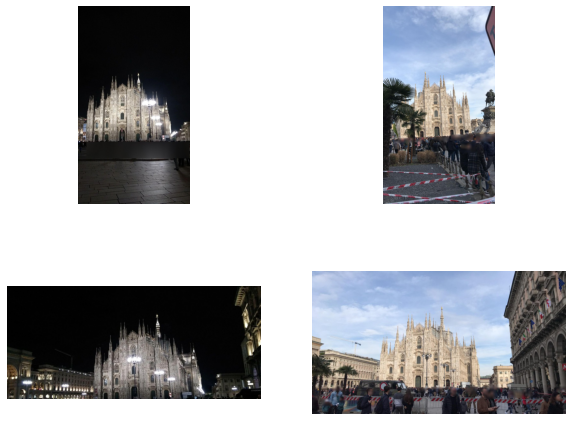

In [80]:
plot_random_images(2, 2, test_df, title=False, landmark_id='114046 171629', figsize=(10,8));

In [81]:
merged_df[merged_df['landmark_id'] == 171629]['category'].iloc[0]

'Duomo_(Milan)'

In [82]:
merged_df[merged_df['landmark_id'] == 114046]['category'].iloc[0]

'Piazza_del_Duomo_(Milan)'

In [83]:
# split by blank and count the lengths of label counts
test_df['landmark_id'].astype(str).map(lambda x: x.split()).map(len).value_counts()

1    117260
2       293
3        23
4         1
Name: landmark_id, dtype: int64

In [84]:
# get all rows with 2 labels
test_df[test_df['landmark_id'].astype(str).map(lambda x: x.split()).map(len) == 2]['landmark_id'].value_counts()

114046 171629    13
121259 170701    10
187645 4465       8
143523 75322      8
170084 35855      6
                 ..
135503 49423      1
137229 172966     1
69742 87105       1
144164 152932     1
104152 39439      1
Name: landmark_id, Length: 121, dtype: int64

Below is an another example of multiple annotations.

Google search suggests that San Giorgio Maggiore is an island in Venice, well-known for its basilica bearing the same name. 

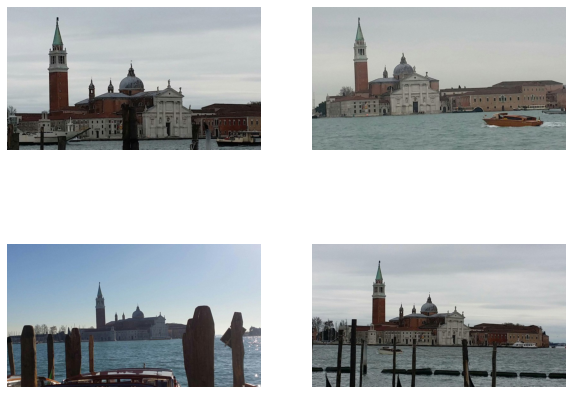

In [85]:
plot_random_images(2, 2, test_df, title=False, landmark_id='187645 4465', figsize=(10,8));

In [86]:
merged_df[merged_df['landmark_id'] == 187645]['category'].iloc[0]

'Basilica_di_San_Giorgio_Maggiore_(Venice)'

In [87]:
merged_df[merged_df['landmark_id'] == 4465]['category'].iloc[0]

'San_Giorgio_Maggiore_(Venice)'

A few transformations are needed still:
- as the max. id of landmark is 203093, I will denote the missing values as 203094
- each label will be a list containing one or more IDs.

In [88]:
test_df['landmark_id'] = test_df['landmark_id'].fillna('203094')

In [89]:
test_df.shape

(117577, 4)

In [90]:
test_df.head()

,id,landmark_id,Usage,file_path
0,e324e0f3e6d9e504,203094,Private,test/e/3/2/e324e0f3e6d9e504.jpg
1,d9e17c5f3e0c47b3,203094,Private,test/d/9/e/d9e17c5f3e0c47b3.jpg
2,1a748a755ed67512,203094,Public,test/1/a/7/1a748a755ed67512.jpg
3,537bf9bdfccdafea,203094,Private,test/5/3/7/537bf9bdfccdafea.jpg
4,13f4c974274ee08b,203094,Private,test/1/3/f/13f4c974274ee08b.jpg


In [91]:
# # save df to disk
# test_df.to_hdf('test.h5', key='test_df', mode='a')

Finally, let's examine some sample images from the test set. 

It is very clear that there are lots of non-landmarks. There are human faces, paintings, cars, animals, etc.

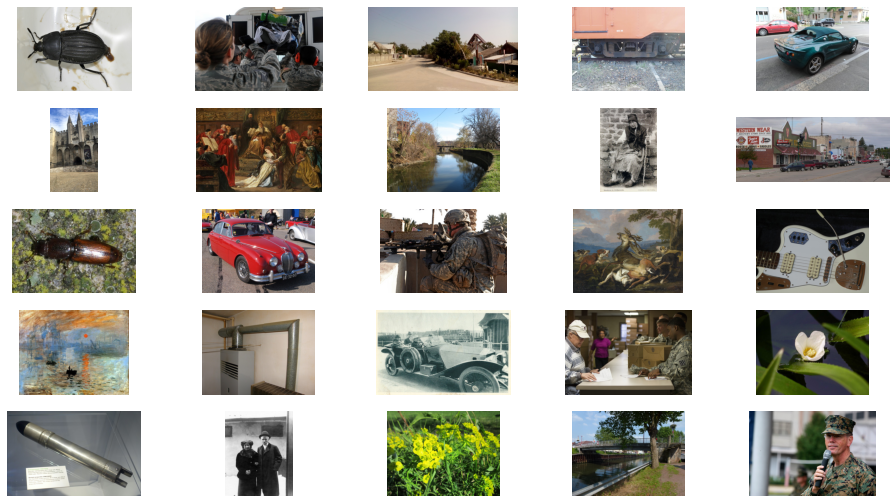

In [92]:
plot_random_images(5, 5, test_df, title=False);